<a target="_blank" rel="noopener noreferrer" href="https://colab.research.google.com/github/ccaudek/ds4psy_2023/blob/main/341_example_prop.ipynb">![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)</a>

# Analisi bayesiana dell'odds-ratio

In questo capitolo, esploreremo l'applicazione degli strumenti statistici descritti nei capitoli precedenti all'analisi bayesiana di due proporzioni. Inizieremo definendo i concetti di odds, odds ratio e logit. Successivamente, mostreremo come effettuare l'analisi bayesiana per il confronto tra due proporzioni.

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pymc as pm
import pymc.sampling_jax
import arviz as az
import warnings

warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=Warning)

/Users/corrado/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 42
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")
sns.set_theme(palette="colorblind")

## Odds

Il termine "odds" rappresenta il rapporto tra la probabilità che un evento si verifichi e la probabilità che l'evento opposto si verifichi. Matematicamente, l'odds può essere calcolato come:

$$ \text{odds} = \frac{\pi}{1-\pi}, $$

dove $\pi$ rappresenta la probabilità dell'evento di interesse.

Mentre una probabilità $\pi$ è sempre compresa tra 0 e 1, gli odds possono variare da 0 a infinito. Per comprendere meglio gli odds lungo questo spettro, consideriamo tre diversi scenari in cui $\pi$ rappresenta la probabilità di un evento.

Se la probabilità di un evento è $\pi = \frac{2}{3}$, allora la probabilità che l'evento non si verifichi è $1 - \pi = \frac{1}{3}$ e gli odds del verificarsi dell'evento sono:

$$ \text{odds} = \frac{2/3}{1-2/3} = 2. $$

Questo significa che la probabilità che l'evento si verifichi è il doppio della probabilità che non si verifichi.

Se, invece, la probabilità dell'evento è $\pi = \frac{1}{3}$, allora gli odds che l'evento si verifichi sono la metà rispetto agli odds che non si verifichi:

$$ \text{odds} = \frac{1/3}{1-1/3} = \frac{1}{2}. $$

Infine, se la probabilità dell'evento è $\pi = \frac{1}{2}$, allora gli odds dell'evento sono pari a 1:

$$ \text{odds} = \frac{1/2}{1-1/2} = 1. $$

### Interpretazione

Gli odds possono essere interpretati nel modo seguente. Consideriamo un evento di interesse con probabilità $\pi \in [0, 1]$ e gli odds corrispondenti $\frac{\pi}{1-\pi} \in [0, \infty)$. Confrontando gli odds con il valore 1, possiamo ottenere una prospettiva sull'incertezza dell'evento:

- Gli odds di un evento sono inferiori a 1 se e solo se le probabilità dell'evento sono inferiori al 50-50, cioè $\pi < 0.5$.
- Gli odds di un evento sono uguali a 1 se e solo se le probabilità dell'evento sono del 50-50, cioè $\pi = 0.5$.
- Gli odds di un evento sono superiori a 1 se e solo se le probabilità dell'evento sono superiori al 50-50, cioè $\pi > 0.5$.

Uno dei motivi per preferire l'uso dell'odds rispetto alla probabilità, nonostante quest'ultima sia un concetto più intuitivo, risiede nel fatto che quando le probabilità si avvicinano ai valori estremi (cioè 0 o 1), è più facile rilevare e apprezzare le differenze tra gli odds piuttosto che le differenze tra le probabilità.

## Odds Ratio

Quando abbiamo una variabile di interesse espressa come proporzione, possiamo confrontare i gruppi utilizzando l'odds ratio. L'odds ratio rappresenta il rapporto tra gli odds di un evento in un gruppo e gli odds dello stesso evento in un secondo gruppo:

$$ OR = \frac{odds_1}{odds_2} = \frac{p_1/(1-p_1)}{p_2/(1-p_2)}. $$

Interpretazione:

- OR = 1: l'appartenenza al gruppo non influenza il risultato;
- OR > 1: l'appartenenza al gruppo specificato al numeratore dell'OR aumenta la probabilità dell'evento rispetto al gruppo specificato al denominatore;
- OR < 1: l'appartenenza al gruppo specificato al numeratore dell'OR riduce la probabilità dell'evento rispetto al gruppo specificato al denominatore.

L'odds ratio è particolarmente utile quando vogliamo confrontare due gruppi e vedere come l'appartenenza a uno di essi influenza la probabilità di un certo evento. Ad esempio, consideriamo uno studio psicologico in cui stiamo valutando l'efficacia di una terapia comportamentale per ridurre l'ansia. Possiamo suddividere i partecipanti allo studio in due gruppi: quelli che sono stati sottoposti al trattamento (gruppo di trattamento) e quelli che non sono stati sottoposti al trattamento (gruppo di controllo).

Calcolando l'odds ratio tra il gruppo di trattamento e il gruppo di controllo, possiamo capire se la terapia ha aumentato o ridotto la probabilità di riduzione dell'ansia. Se l'odds ratio è maggiore di 1, significa che la terapia ha aumentato le probabilità di riduzione dell'ansia; se è inferiore a 1, significa che il trattamento ha ridotto le probabilità di riduzione dell'ansia. L'odds ratio ci fornisce quindi una misura dell'effetto della terapia rispetto al controllo.

## Logaritmo dell'Odds Ratio

Il logaritmo dell'odds ratio è una trasformazione matematica molto utilizzata nell'analisi statistica, specialmente nella regressione logistica. Essa permette di rendere l'odds ratio interpretabile su una scala lineare, semplificando l'analisi e l'interpretazione dei risultati.

La formula per calcolare il logaritmo dell'odds ratio è la seguente:

$$ \text{logit}(OR) = \log(OR) = \log\left(\frac{odds_1}{odds_2}\right). $$

In altre parole, il logaritmo dell'odds ratio è il logaritmo naturale del rapporto tra gli odds di un evento nel primo gruppo e gli odds dello stesso evento nel secondo gruppo.

### Interpretazione

L'interpretazione del logaritmo dell'odds ratio è più intuitiva rispetto all'odds ratio stesso. Una variazione di una unità nel logaritmo dell'odds ratio corrisponde a un cambiamento costante nell'odds ratio stesso.

Se il logaritmo dell'odds ratio è positivo, significa che l'odds dell'evento nel primo gruppo è maggiore rispetto al secondo gruppo. Più il valore del logaritmo dell'odds ratio si avvicina a zero, più l'odds dell'evento nei due gruppi si avvicina a essere simile.

Se, invece, il logaritmo dell'odds ratio è negativo, l'odds dell'evento nel primo gruppo è inferiore rispetto al secondo gruppo. Un valore di logaritmo dell'odds ratio vicino a zero indica che l'odds dell'evento è simile nei due gruppi.

## Analisi bayesiana delle proporzioni

Una volta compresi i concetti di odds, odds ratio e logit, possiamo procedere all'analisi bayesiana delle proporzioni. Questo approccio ci consente di confrontare le proporzioni di due gruppi e ottenere stime delle probabilità a posteriori e degli intervalli di credibilità.

L'analisi bayesiana si basa sull'applicazione del teorema di Bayes per aggiornare le nostre conoscenze a priori con l'evidenza fornita dai dati osservati. Questo ci permette di ottenere una distribuzione a posteriori delle quantità di interesse, come l'odds ratio.

In questo capitolo, analizzeremo i dati riguardanti i voti del primo parziale di Psicometria dell'anno accademico 2022-2023, suddividendo gli studenti per genere (femmine e maschi). Ci concentreremo sull'evento dicotomico relativo a "aver impiegato un tempo maggiore della media per concludere l'esame".

I dati di cui disponiamo sono i seguenti:

- Tra le studentesse, 108 hanno impiegato un tempo maggiore della media su un totale di 155.
- Tra gli studenti maschi, 28 hanno impiegato un tempo maggiore della media su un totale di 57.

Per confrontare le prestazioni dei due gruppi, useremo l'odds ratio, così da confrontare le probabilità dell'evento in questione tra i due gruppi. Iniziamo calcolare la probabilità che una studentessa impieghi un tempo maggiore della media nel primo parziale di Psicometria:

$$ p_f = \frac{108}{155} \approx 0.6968. $$

Successivamente, calcoliamo gli odds per le femmine:

$$ odds_f = \frac{p_f}{1 - p_f} \approx 2.2979. $$

Questo ci dice che per le femmine ci sono circa due "successi" (ossia impiegare un tempo maggiore della media) per ogni "insuccesso" (impiegare un tempo minore della media).

Procediamo calcolando la probabilità che un maschio impieghi un tempo maggiore della media nel primo parziale di Psicometria:

$$ p_m = \frac{28}{57} \approx 0.4912. $$

Calcoliamo ora gli odds per i maschi:

$$ odds_m = \frac{p_m}{1 - p_m} \approx 0.9655. $$

Questo ci dice che per i maschi c'è circa lo stesso numero di "successi" (ossia impiegare un tempo maggiore della media) e "insuccessi" (impiegare un tempo minore della media).

Infine, confrontiamo gli odds tra le femmine e i maschi per calcolare l'odds ratio (OR):

$$ OR = \frac{odds_f}{odds_m} \approx 2.3799. $$

Le femmine hanno un'odds di impiegare un tempo superiore alla media che è 2.38 volte quello dei maschi nel completamento del primo parziale del corso di Psicometria. In altre parole, le femmine tendono ad avere una probabilità più elevata di impiegare un tempo maggiore della media rispetto ai maschi in questo esame. 

## Analisi Bayesiana dell'Odds Ratio

Nella nostra analisi, ci focalizziamo sull'Odds Ratio (OR) per valutare la differenza nel tempo impiegato tra maschi e femmine durante il primo parziale di Psicometria. L'OR fornisce una stima puntuale della differenza basata sul nostro campione specifico.

Tuttavia, per realizzare un'inferenza statistica robusta, è essenziale prendere in considerazione la variabilità campionaria; in altre parole, la potenziale variabilità dell'OR se calcolato su diversi campioni. Questo ci obbliga non solo ad analizzare le specificità del nostro campione, ma anche a fare inferenze sulle proprietà della popolazione da cui il campione proviene.

Per affrontare questa questione, ricorriamo a un approccio bayesiano, mediante il quale costruiamo la distribuzione a posteriori dell'OR. A partire da questa distribuzione, determiniamo un intervallo di credibilità del 90%, che rappresenta l'intervallo entro il quale, con il 90% di confidenza, possiamo aspettarci che ricada il vero valore dell'OR della popolazione.

Se questo intervallo non include il valore 1, disponiamo di una solida evidenza (con un livello di credibilità del 90%) che la differenza tra maschi e femmine nel nostro campione corrisponde a una differenza reale nella popolazione, il che suggerisce che non si tratta di un artefatto generato dalla variabilità campionaria. In altre parole, possiamo affermare con ragionevole certezza che la differenza osservata nel tempo impiegato tra maschi e femmine è un tratto che può essere generalizzato a tutti gli esami di Psicometria.

D'altro canto, se l'intervallo di credibilità includesse il valore 1, ciò indicherebbe che la differenza osservata nel nostro campione potrebbe non riflettere una differenza significativa nella popolazione generale, suggerendo che potrebbe essere una peculiarità del nostro campione specifico.

L'analisi bayesiana e il calcolo dell'intervallo di credibilità verranno condotti utilizzando il pacchetto PyMC.

Iniziamo a specificare i dati.

In [3]:
n1 = 155
y1 = 108
n2 = 57
y2 = 28

Definiamo ora il modello nella sintassi richiesta da PyMC.

In [4]:
with pm.Model() as model:
    # Define the priors for the two proportions
    p1 = pm.Beta("p1", alpha=2, beta=2)
    p2 = pm.Beta("p2", alpha=2, beta=2)

    # Define the likelihood functions for the two proportions
    likelihood1 = pm.Binomial("likelihood1", n=n1, p=p1, observed=y1)
    likelihood2 = pm.Binomial("likelihood2", n=n2, p=p2, observed=y2)

    # Define the difference of odds model
    odds_ratio = pm.Deterministic("odds_ratio", (p1 / (1 - p1)) / (p2 / (1 - p2)))

Ecco una spiegazione dettagliata di ciascuna parte del modello:

```python
with pm.Model() as model:
```
Questa linea di codice crea un nuovo modello statistico bayesiano utilizzando PyMC. Tutte le distribuzioni e le variabili definite all'interno di questo blocco di codice saranno parte del modello.

```python
    p1 = pm.Beta("p1", alpha=2, beta=2)
    p2 = pm.Beta("p2", alpha=2, beta=2)
```
Qui stiamo definendo due distribuzioni a priori per due parametri, `p1` e `p2`, utilizzando una distribuzione beta. La distribuzione beta è comunemente usata come prior per parametri che rappresentano probabilità perché è definita nell'intervallo (0,1), il che la rende appropriata per modellare una probabilità. In questo caso, entrambi i priori sono impostati con parametri α=2 e β=2, il che significa che stiamo dando un prior non informativo (o debolmente informativo) alle proporzioni, suggerendo che prima di vedere i dati abbiamo una credenza equamente bilanciata riguardo i valori di `p1` e `p2`.

```python
    likelihood1 = pm.Binomial("likelihood1", n=n1, p=p1, observed=y1)
    likelihood2 = pm.Binomial("likelihood2", n=n2, p=p2, observed=y2)
```
In queste linee, definiamo le funzioni di verosimiglianza per i nostri dati utilizzando una distribuzione binomiale. Qui, `n1` e `n2` sono il numero di tentativi e `y1` e `y2` sono il numero di "successi" osservati nei due gruppi che stiamo confrontando. `p1` e `p2` sono le probabilità di successo per ciascun gruppo.

```python
    odds_ratio = pm.Deterministic("odds_ratio", (p1 / (1 - p1)) / (p2 / (1 - p2)))
```
Infine, definiamo una variabile deterministica per calcolare il rapporto delle probabilità (odds ratio) basato su `p1` e `p2`. L'odds ratio è calcolato come $(\frac{p1}{1-p1}) / (\frac{p2}{1-p2})$, che è una misura del rapporto delle odds di successo tra i due gruppi.

In sintesi, questo modello è impostato per fare inferenza bayesiana sulle differenze tra due proporzioni (qui rappresentate da `p1` e `p2`) attraverso la stima dell'odds ratio. Dopo aver definito questo modello, procediamo a eseguire il campionamento per ottenere stime posteriori per `p1`, `p2`, e l'odds ratio.

In [5]:
with model:
    trace = pm.sampling_jax.sample_numpyro_nuts(draws=2000, tune=1000)

Compiling...


Compilation time = 0:00:00.781476


Sampling...


  0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/3000 [00:00<?, ?it/s]

  0%|                                                                                  | 0/3000 [00:00<?, ?it/s]

Compiling.. :   0%|                                                                    | 0/3000 [00:00<?, ?it/s]

Running chain 3:   0%|                                                                 | 0/3000 [00:01<?, ?it/s]

Running chain 0:   0%|                                                                 | 0/3000 [00:01<?, ?it/s]

Running chain 1:   0%|                                                                 | 0/3000 [00:01<?, ?it/s]

Running chain 2:   0%|                                                                 | 0/3000 [00:01<?, ?it/s]

Running chain 0: 100%|████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2445.35it/s]


Running chain 1: 100%|████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2447.73it/s]


Running chain 2: 100%|████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2450.19it/s]


Running chain 3: 100%|████████████████████████████████████████████████████| 3000/3000 [00:01<00:00, 2452.53it/s]


Sampling time = 0:00:01.545654


Transforming variables...


Transformation time = 0:00:00.082285


## Diagnostica delle catene markoviane

Prima di esaminare i risultati, eseguiamo la diagnostica delle catene markoviane.

### Mixing

Il trace plot precedente dimostra un buon mixing. Questo è evidenza che il campionamento MCMC ha raggiunto uno stato stazionario.


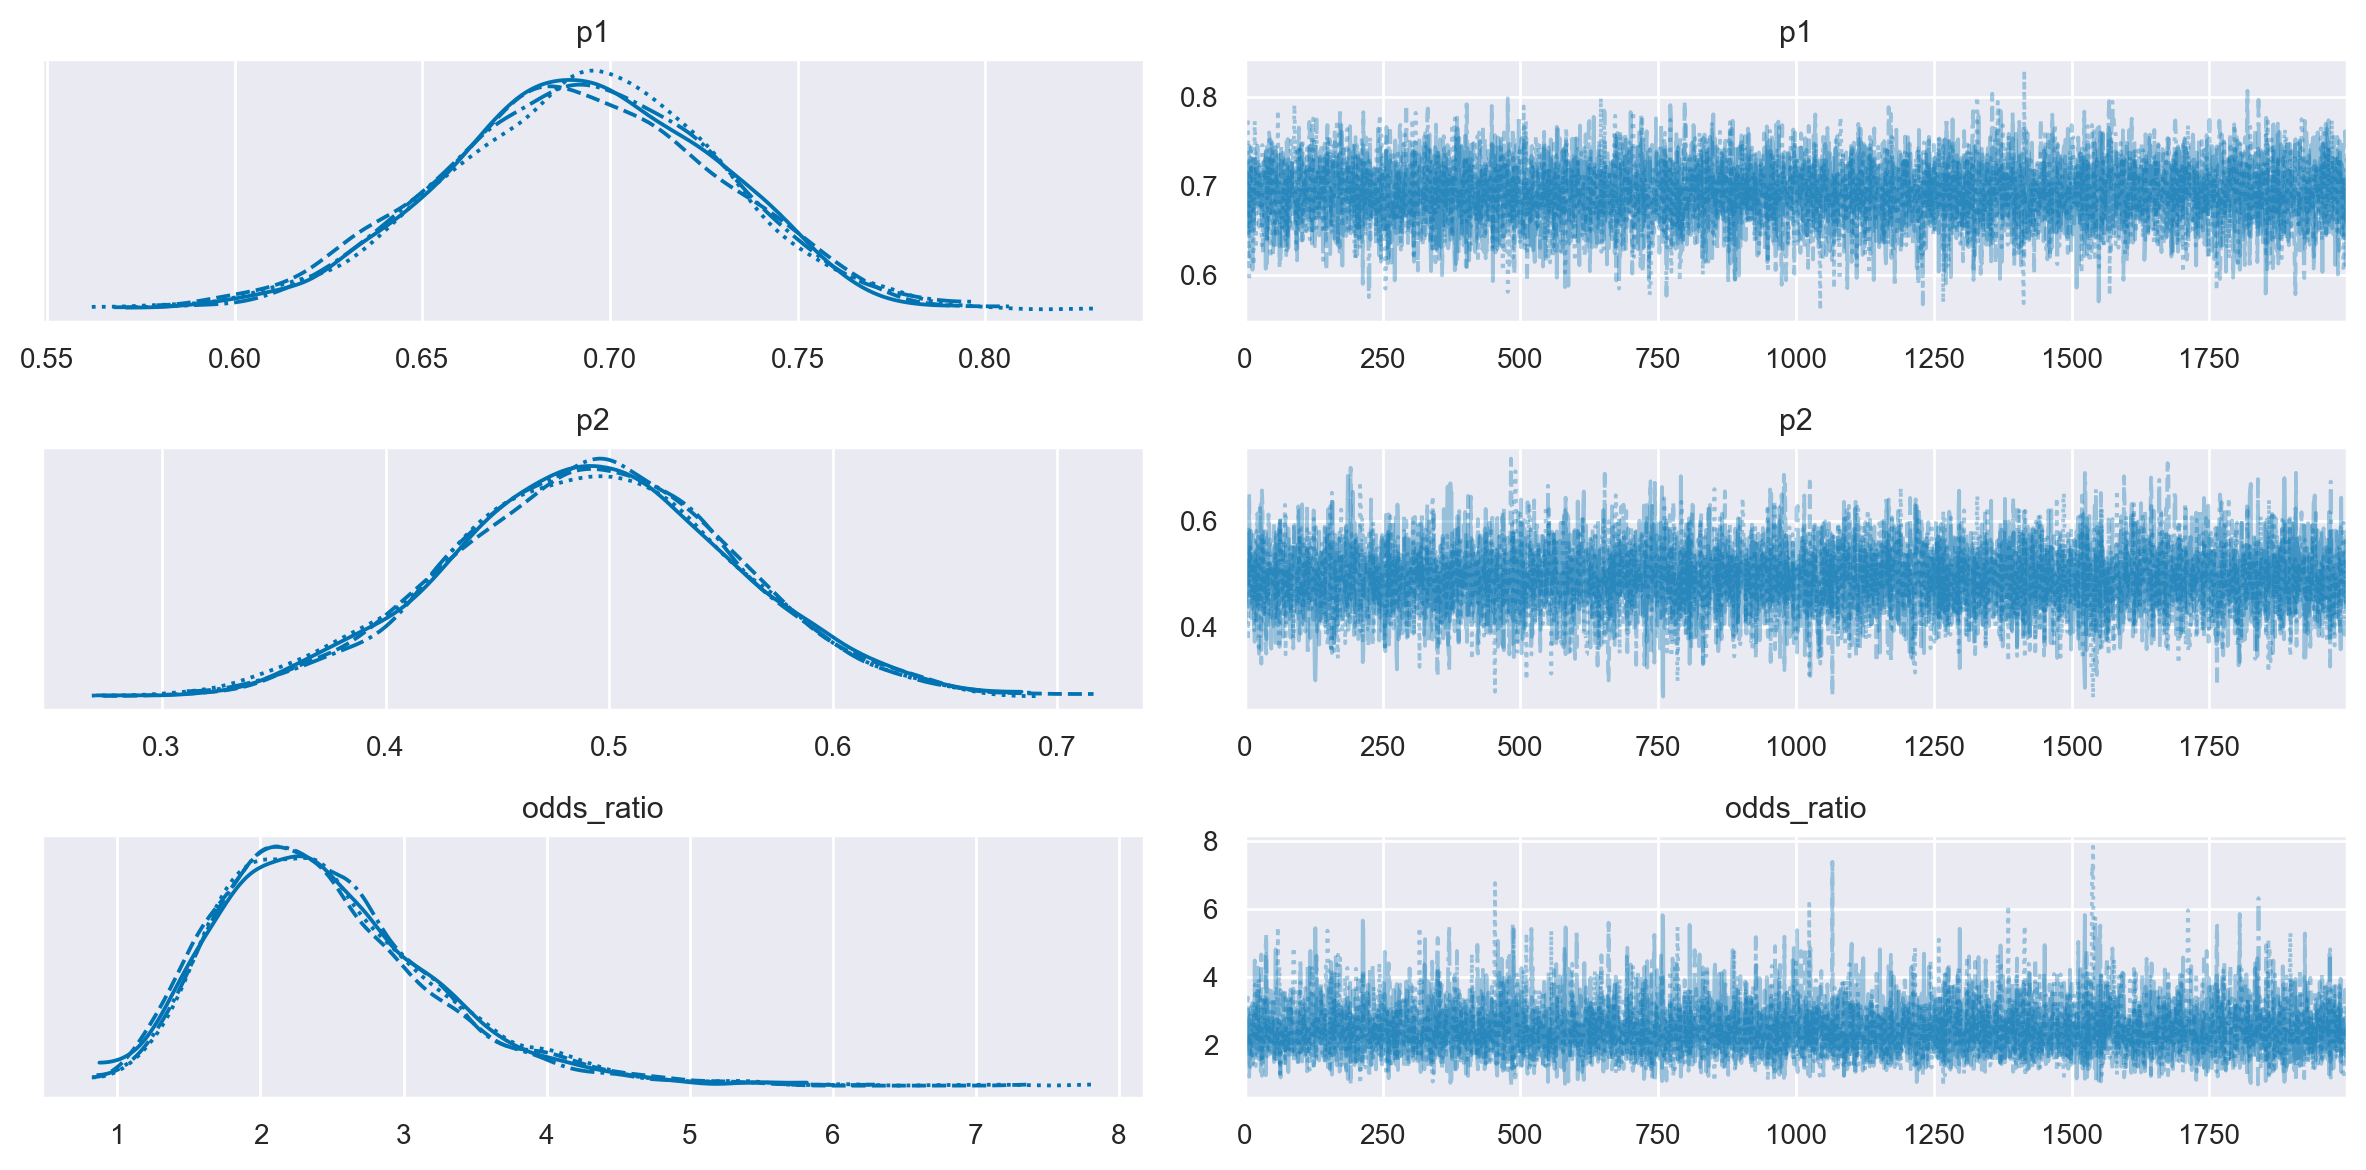

In [6]:
az.plot_trace(trace)
plt.tight_layout()

### Numerosità campionaria effettiva

Quando si utilizzano metodi di campionamento MCMC, è ragionevole chiedersi se un particolare campione estratto dalla distribuzione a posteriori sia sufficientemente grande per calcolare con sicurezza le quantità di interesse, come una media o un HDI. Questo non è qualcosa che possiamo rispondere direttamente guardando solo il numero di punti della catena MCMC, e il motivo è che i campioni ottenuti dai metodi MCMC hanno un certo grado di autocorrelazione, quindi la quantità effettiva di informazioni contenute in quel campione sarà inferiore a quella che otterremmo da un campione iid della stessa dimensione. Possiamo pensare alla dimensione del campione effettivo (ESS) come a un stimatore che tiene conto dell’autocorrelazione e fornisce il numero di estrazioni che avremmo se il nostro campione fosse effettivamente iid.

Per le catene buone, solitamente, il valore della dimensione del campione effettivo sarà inferiore al numero di campioni. Ma l’ESS può essere in realtà più grande del numero di campioni estratti. Quando si utilizza il campionatore NUTS, valori di ESS maggiori del numero totale di campioni possono verificarsi per parametri le cui distribuzioni posteriori sono vicine alla Gaussiana e che sono quasi indipendenti da altri parametri nel modello.

Nell'output di PyCM si considera ESS_BULK.  Un euristica è che deve essere almeno uguale a 400. Nel caso presente questo si verifica, quindi il valore ESS_BULK non fornisce alcuna evidenza di cattivo mixing. 

In [7]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p1,0.692,0.036,0.626,0.760,0.000,0.000,6623.0,5197.0,1.0
p2,0.492,0.064,0.363,0.605,0.001,0.001,6819.0,5098.0,1.0
odds_ratio,2.450,0.772,1.210,3.963,0.010,0.007,6695.0,4977.0,1.0


### R hat

In condizioni molto generali, i metodi di Markov chain Monte Carlo hanno garanzie teoriche che otterranno la risposta corretta indipendentemente dal punto di partenza. Sfortunatamente, tali garanzie sono valide solo per campioni infiniti. Quindi, nella pratica, abbiamo bisogno di modi per stimare la convergenza per campioni finiti. Un’idea diffusa è quella di generare più di una catena, partendo da punti molto diversi e quindi controllare le catene risultanti per vedere se sembrano simili tra loro. Questa nozione intuitiva può essere formalizzata in un indicatore numerico noto come R-hat. Esistono molte versioni di questo stimatore, poiché è stato perfezionato nel corso degli anni. In origine il R-hat veniva interpretato come la sovrastima della varianza dovuta al campionamento MCMC finito. Ciò significa che se si continua a campionare all’infinito si dovrebbe ottenere una riduzione della varianza della stima di un fattore R-hat. E quindi il nome “fattore di riduzione potenziale della scala” (*potential scale reduction factor*), con il valore target di 1 che significa che aumentare il numero di campioni non ridurrà ulteriormente la varianza della stima. Tuttavia, nella pratica è meglio pensarlo solo come uno strumento diagnostico senza cercare di sovra-interpretarlo.

L’R-hat per il parametro theta viene calcolato come la deviazione standard di tutti i campioni di theta, ovvero includendo tutte le catene insieme, diviso per la radice quadratica media delle deviazioni standard separate all’interno della catena. Il calcolo effettivo è un po’ più complesso ma l’idea generale è questa. Idealmente dovremmo ottenere un valore di 1, poiché la varianza tra le catene dovrebbe essere la stessa della varianza all’interno della catena. Da un punto di vista pratico, valori di R-hat inferiori a 1.1 sono considerati sicuri.

Nel caso presente questo si verifica. Possiamo ottenere R hat con Arviz:

In [8]:
az.rhat(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    p1          float64 1.001
    p2          float64 1.0
    odds_ratio  float64 1.0

Il valore di $\hat{R}$, al massimo, raggiunge il valore di 1.001. Essendo il valore molto simile a 1 nel caso presente, possiamo dire che non ci sono evidenza di assenza di convergenza.

### Errore standard di Monte Carlo 

Quando si utilizzano metodi MCMC introduciamo un ulteriore livello di incertezza poiché stiamo approssimando la posteriore con un numero finito di campioni. Possiamo stimare la quantità di errore introdotta utilizzando l’errore standard di Monte Carlo (MCSE). L’MCSE tiene conto del fatto che i campioni non sono veramente indipendenti l’uno dall’altro e sono in realtà calcolati dall’ESS. Mentre i valori di ESS e R-hat sono indipendenti dalla scala dei parametri, la statistica MCSE non lo è. Se vogliamo riportare il valore di un parametro stimato al secondo decimale, dobbiamo essere sicuri che MCSE sia al di sotto del secondo decimale altrimenti, finiremo, erroneamente, per riportare una precisione superiore a quella che abbiamo realmente. Dovremmo controllare MCSE solo una volta che siamo sicuri che ESS sia abbastanza alto e R-hat sia abbastanza basso; altrimenti, MCSE non è utile.

Nel nostro caso il MCSE è sufficientemente piccolo.

In [9]:
az.mcse(trace)

<xarray.Dataset>
Dimensions:     ()
Data variables:
    p1          float64 0.0004436
    p2          float64 0.0007699
    odds_ratio  float64 0.009531

Come per l’ESS, l’MCSE varia nello spazio dei parametri e quindi potremmo anche volerlo valutare per diverse regioni dello spazio dei parametri.

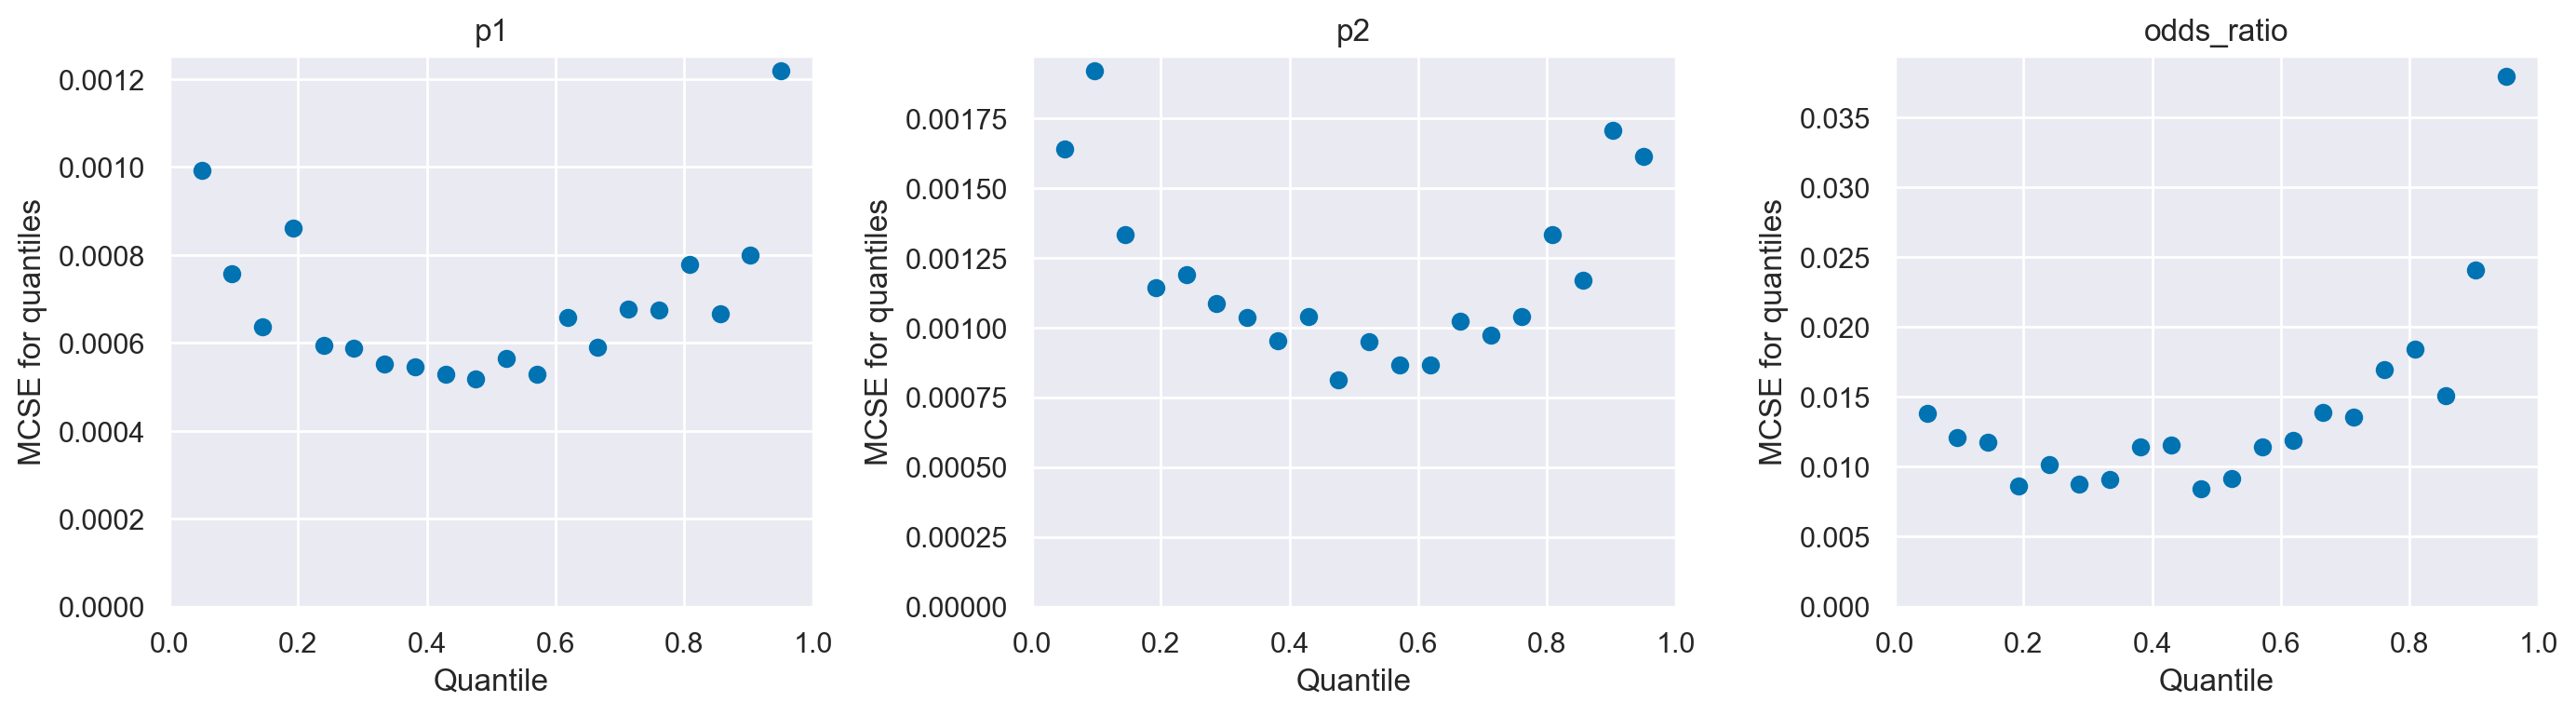

In [10]:
az.plot_mcse(trace, figsize=(14, 4))
plt.tight_layout()

L'errore standard di Monte Carlo ci informa della precisione della stima ottenuta usando il metodo MCMC. Non possiamo riportare una precisione dei risultati maggiore di quella indicata dalla MCSE. Pertanto, per il caso presente relativo all'Odds Ratio (OR), possiamo affermare che la precisione massima raggiungibile è limitata a due decimali.

### Autocorrelazione

L’autocorrelazione riduce la quantità effettiva di informazioni contenute in un campione e quindi è qualcosa che vogliamo mantenere al minimo. Possiamo ispezionare direttamente l’autocorrelazione con `az.plot_autocorr`.

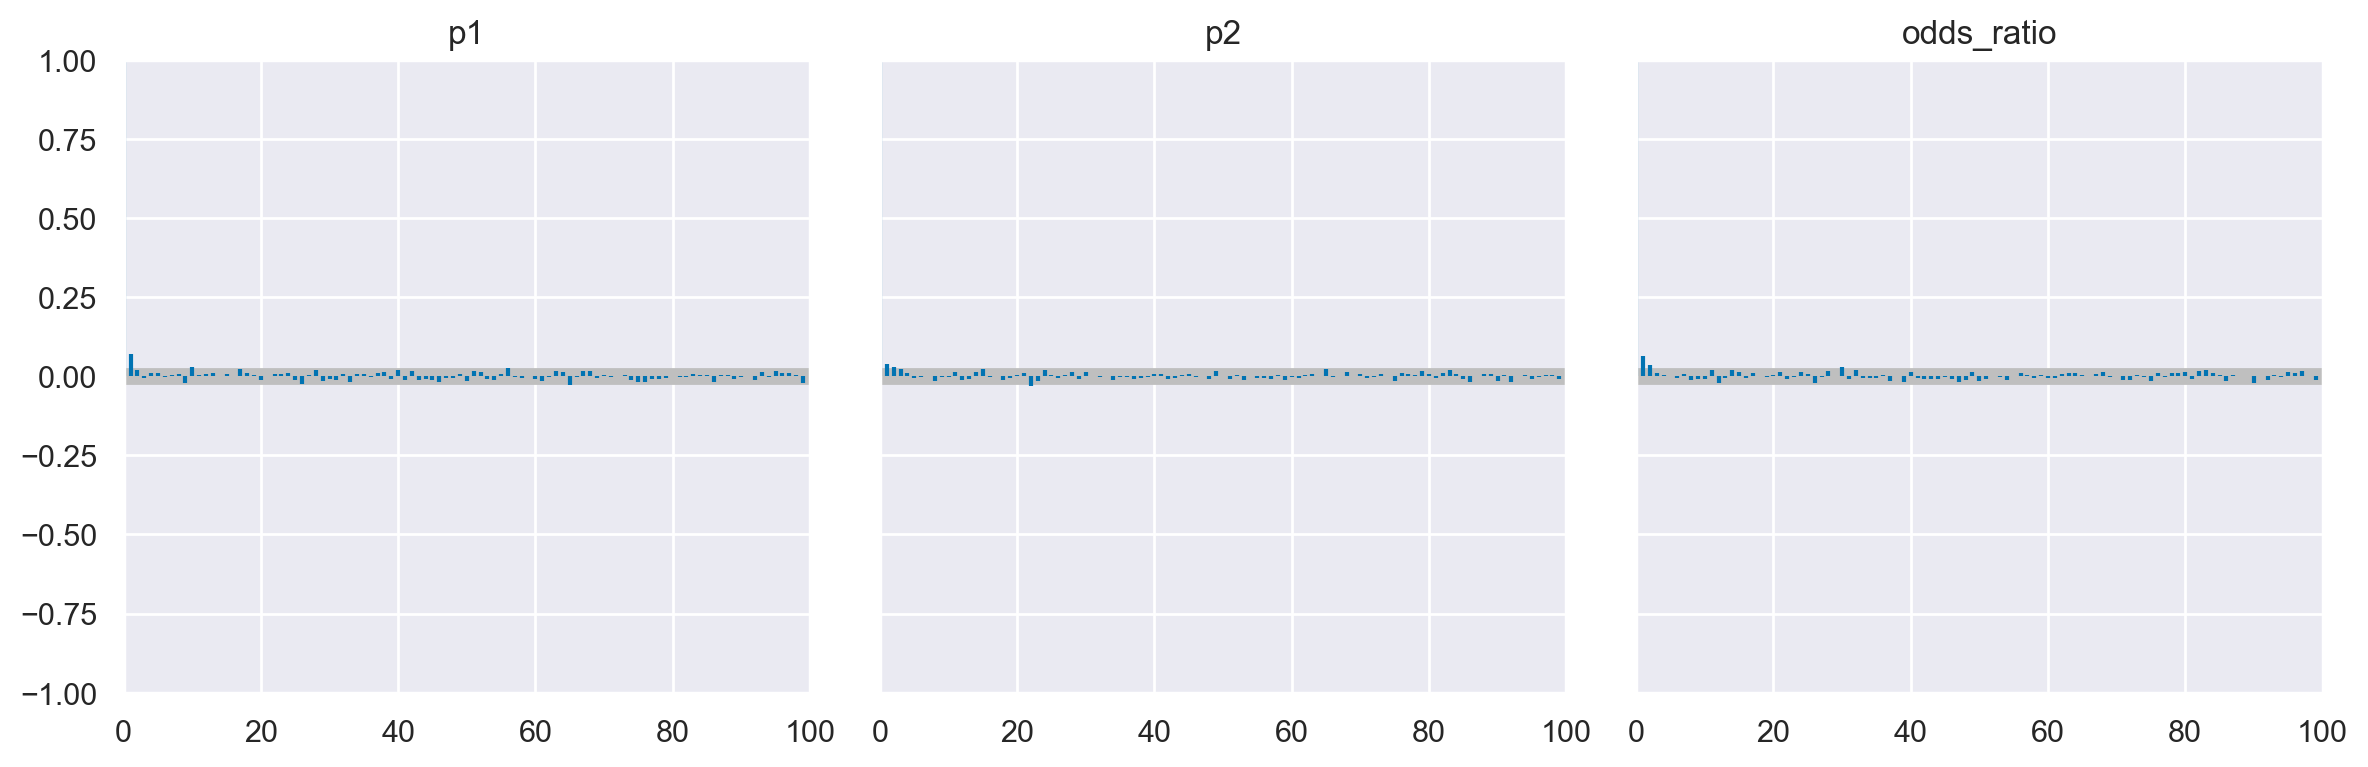

In [11]:
az.plot_autocorr(trace, combined=True, figsize=(12, 4))
plt.tight_layout()
plt.show()

### Rank Plots

I grafici dei ranghi sono un altro strumento diagnostico visivo che possiamo utilizzare per confrontare il comportamento del campionamento sia all’interno che tra le catene. I grafici dei ranghi, in parole semplici, sono istogrammi dei campioni della distribuzione a posteriori espressi in termini di ranghi. Nei grafici dei ranghi, i ranghi sono calcolati combinando prima tutte le catene ma poi rappresentando i risultati separatamente per ogni catena. Se tutte le catene stimano la stessa distribuzione, ci aspettiamo che i ranghi abbiano una distribuzione uniforme. Inoltre, se i grafici dei ranghi di tutte le catene sembrano simili, ciò indica un buon mix delle catene.

Possiamo ottenere i grafici dei ranghi con `az.plot_rank`.

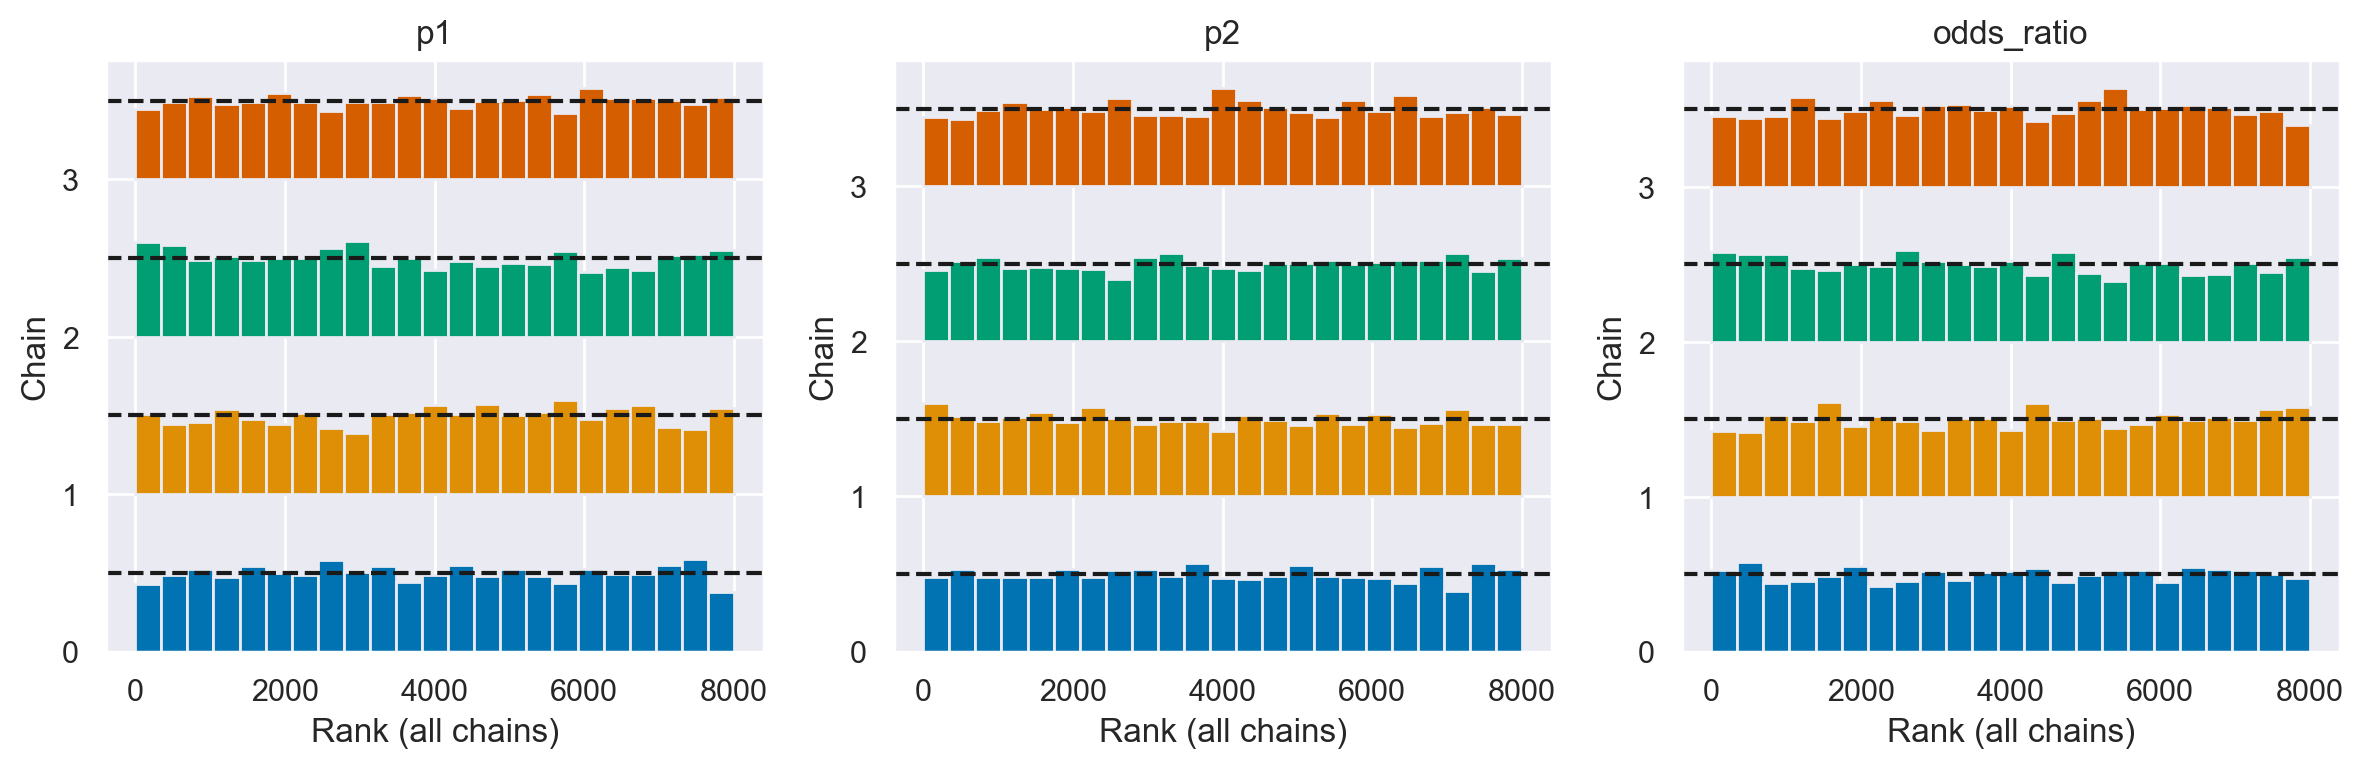

In [12]:
az.plot_rank(trace, kind="bars", figsize=(12, 4))
plt.tight_layout()

Una rappresentazione alternativa è la seguente.

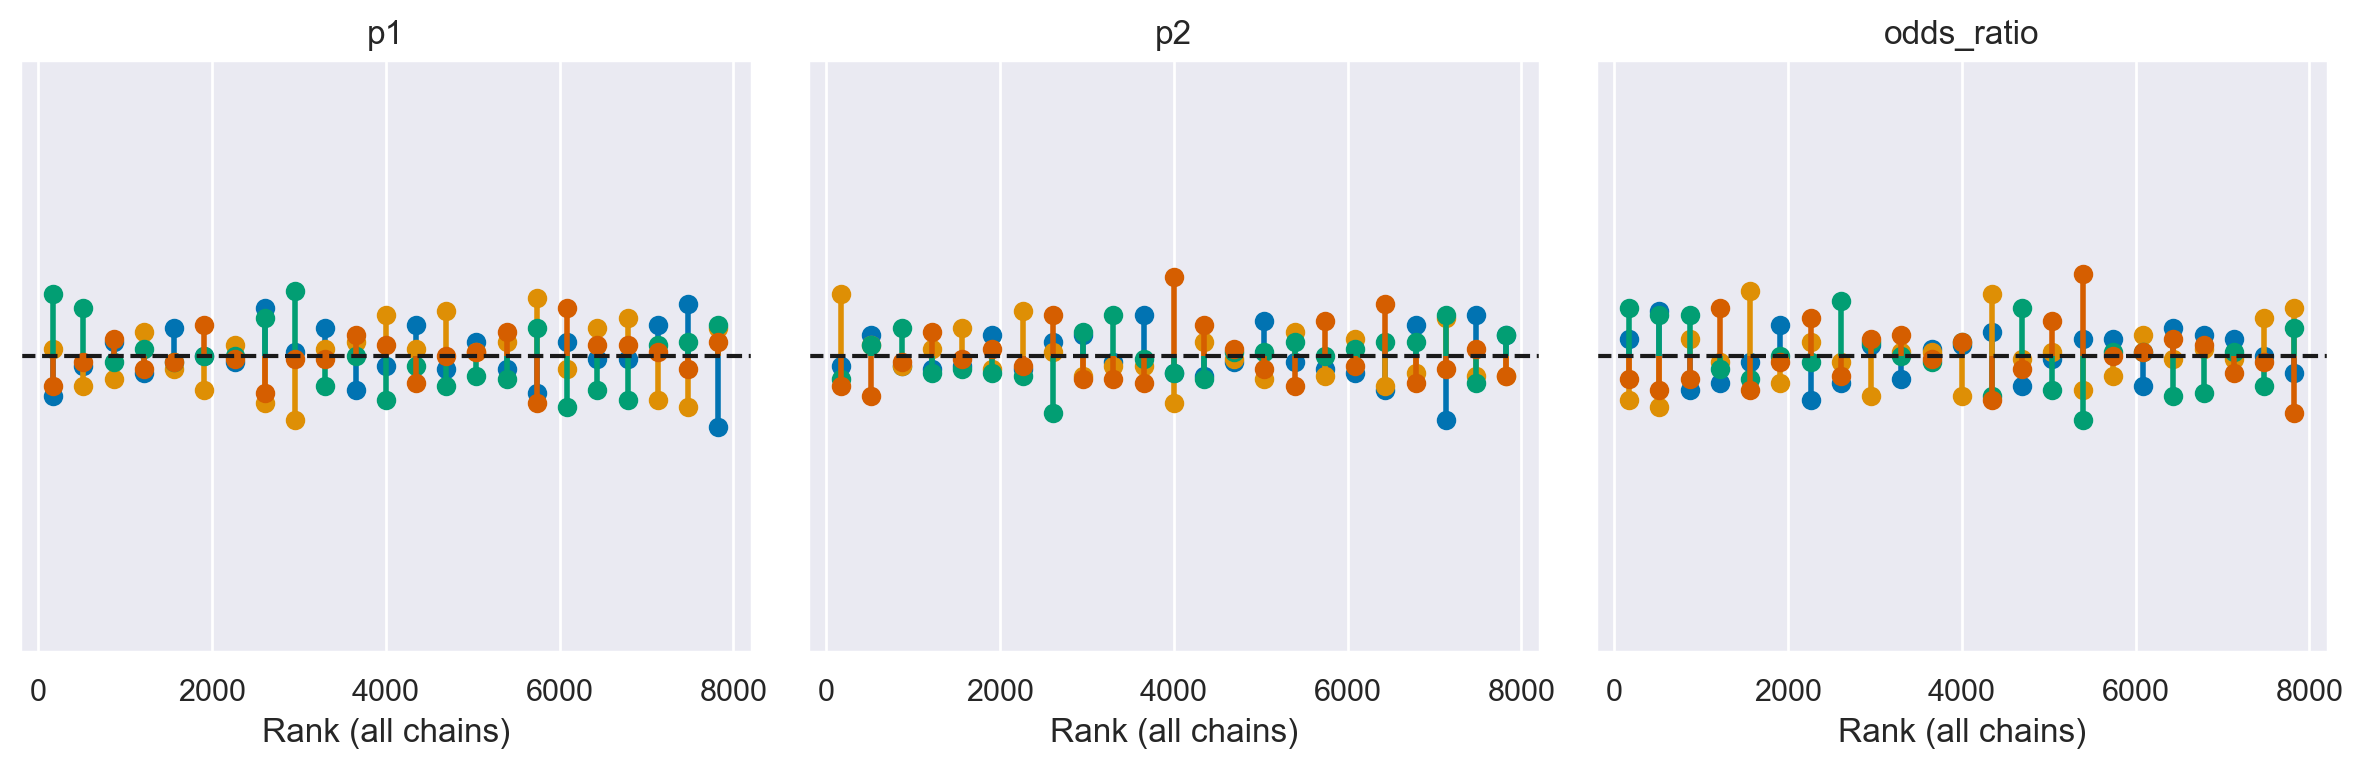

In [13]:
az.plot_rank(trace, kind="vlines", figsize=(12, 4))
plt.tight_layout()
plt.show()

Possiamo vedere nella figura che i ranghi sono molto simili ad una distribuzione uniforme e che tutte le catene sono simili tra loro senza alcuno scostamento distintivo.

### Divergenza

Finora abbiamo diagnosticato il funzionamento di un campionatore esaminando i campioni generati. Un altro modo per eseguire una diagnosi è monitorare il comportamento dei meccanismi interni del metodo di campionamento. Un esempio importante di tali diagnosi è il concetto di divergenza presente in alcuni metodi Hamiltonian Monte Carlo (HMC). Le divergenze (o transizioni divergenti) sono un modo potente e sensibile per diagnosticare i campioni e funzionano come complemento alle diagnosi che abbiamo visto nelle sezioni precedenti. 

PyMC riporta il numero di transizioni divergenti. Se non viene riportato alcun messaggio che informa della presenza di transizioni divergenti, questo vuol dire che la distribuzione a posteriori è stata stimata correttamente.

### BFMI

Il BFMI (Fraction of Missing Information) serve a valutare quanto bene il processo di campionamento si allinea con la distribuzione della "energia" associata a ciascun campione. Nel contesto del campionamento Hamiltoniano, il termine "energia" si riferisce a una quantità calcolata durante il processo di campionamento che aiuta a valutare quanto è probabile un certo set di parametri alla luce dei dati osservati e del modello statistico in esame.

Il BFMI è uno strumento che ci aiuta a valutare se il processo di campionamento sta "esplorando" adeguatamente lo spazio dei parametri possibili. In altre parole, ci dice se il nostro processo di campionamento sta dando un'immagine accurata delle regioni dello spazio dei parametri che sono realmente plausibili dati i nostri dati e il nostro modello. Un valore BFMI basso indica che il campionamento non è riuscito a esplorare adeguatamente alcune regioni dello spazio dei parametri che dovrebbero essere state esplorate, e quindi i risultati del campionamento potrebbero non essere affidabili.

Generalmente, un valore inferiore a 0.3 indica un campionamento insufficiente. 

Nel caso presente, dal momento che i valori BFMI sono superiori a 0.3 per tutte le catene, sembra che il processo di campionamento sia riuscito a esplorare adeguatamente lo spazio dei parametri.

In [14]:
az.bfmi(trace)

array([1.13078911, 1.06749175, 1.18060685, 1.11997393])

La validazione del processo di campionamento può essere efficacemente eseguita analizzando graficamente le quantità note come "energy transition" e "marginal energy". Queste metriche sono strettamente legate alla funzione obiettivo che l'algoritmo di campionamento intende ottimizzare e giocano un ruolo cruciale nel rilevare potenziali problematiche che possono emergere durante il campionamento.

- **Energy transition**: questa metrica illustra l'"energia" calcolata in ogni singolo passo dell'algoritmo di campionamento, offrendo una visione dettagliata delle fluttuazioni che intervengono ad ogni iterazione. Facilita l'identificazione delle aree dello spazio dei parametri dove l'algoritmo potrebbe incontrare difficoltà nel campionare in modo corretto.
- **Marginal energy**: fornisce un profilo dell'"energia" marginale per l'intero set di campioni, riflettendo l'"energia" media in ogni punto del campione. È una rappresentazione grafica dell'"energia" associata alla distribuzione a posteriori che si intende campionare.

Per un'analisi diagnostica efficace, è auspicabile che il tracciato dell'"energy transition" coincida sostanzialmente con quello della "marginal energy". Tale congruenza è indicativa di una esplorazione ben riuscita dello spazio dei parametri, assicurando che le regioni ad alta probabilità nella distribuzione a posteriori siano state correttamente campionate. Pertanto, una buona sovrapposizione tra i grafici delle due metriche attesterebbe un funzionamento ottimale del modello, conferendo un grado di affidabilità elevato alle stime dei parametri derivanti dal processo di campionamento.

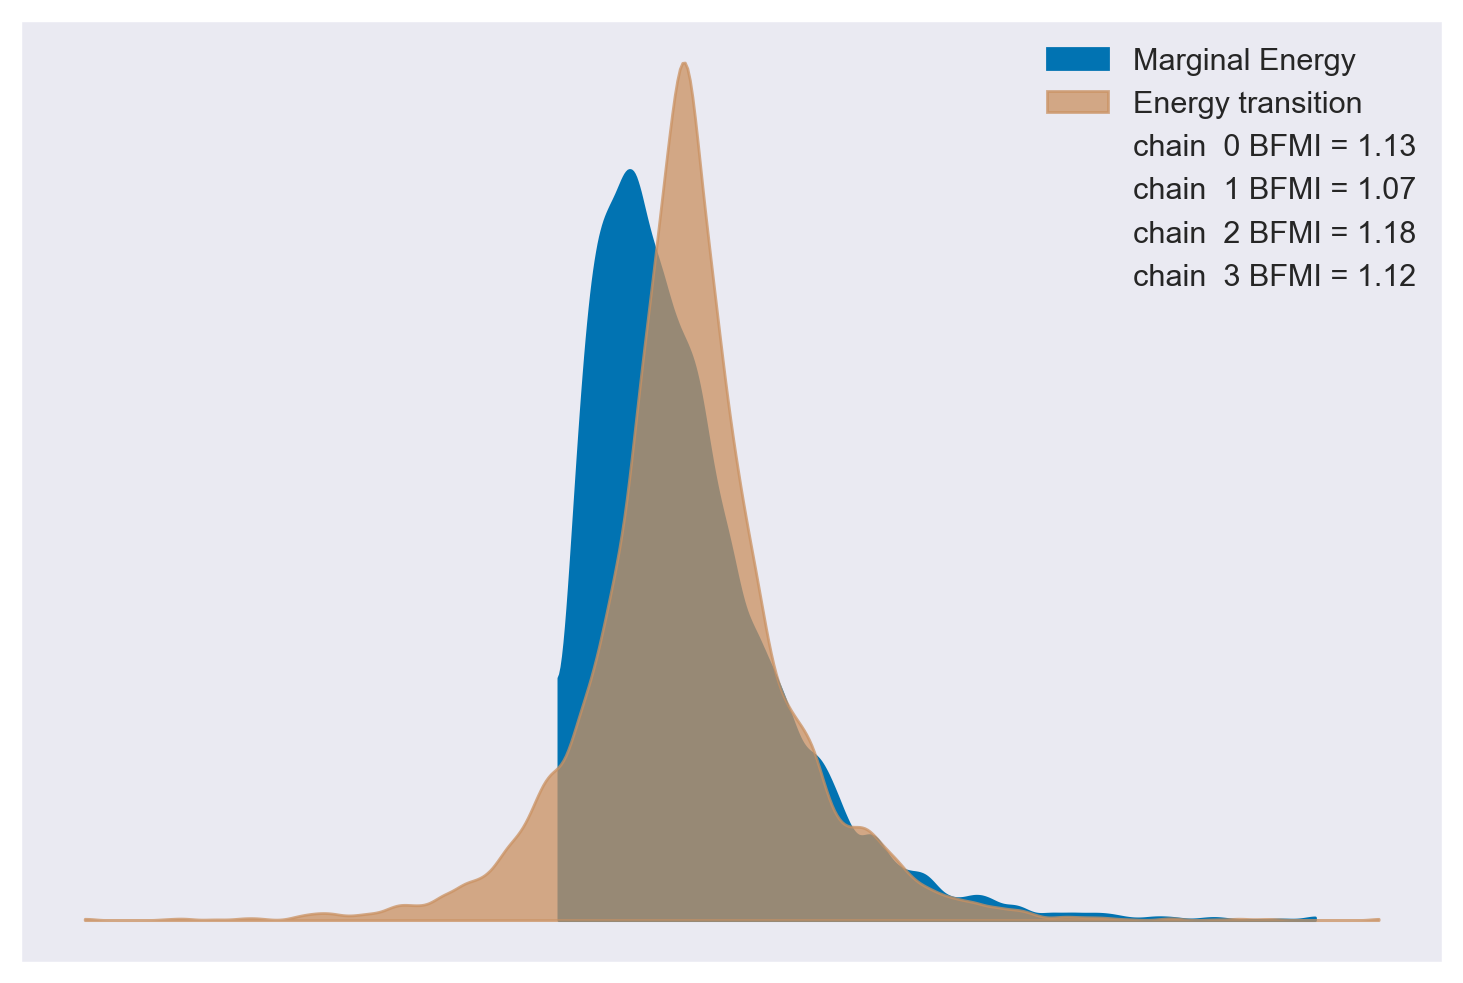

In [15]:
_ = az.plot_energy(trace)

### Conclusione

In questo capitolo abbiamo approfondito l'analisi bayesiana focalizzandoci sulla stima dell'odds ratio (OR). I risultati della diagnosi delle catene Markoviane non evidenziano problematiche relative alla convergenza dell'algoritmo o discrepanze nel modello statistico adottato, permettendoci di procedere con l'analisi dei risultati ottenuti.

L'analisi ha determinato un valore a posteriori per l'OR di 2.45, accompagnato da un intervallo di credibilità del 94% che varia tra 1.16 e 3.96. Significativamente, questo intervallo non comprende il valore 1, consentendoci di affermare, con un grado di certezza del 94%, che le studentesse tendono a impiegare un tempo superiore alla media rispetto ai loro colleghi maschi.

È importante notare che un approccio più diretto alla questione avrebbe implicato un confronto diretto dei tempi impiegati da studentesse e studenti (senza discretizzare i dati) attraverso un test sulle medie di campioni indipendenti, fornendo così una visione diretta della differenza temporale tra i due gruppi.

La scelta di focalizzare l'analisi bayesiana sull'odds ratio è stata guidata da una motivazione didattica volta ad illustrare questo tipo di analisi nel contesto del confronto tra proporzioni in diversi gruppi. 

L'approccio bayesiano che abbiamo adottato ha non solo facilitato la valutazione della credibilità dell'effetto osservato, ma ha anche permesso di determinare se la differenza identificata fosse indicativa di una tendenza più generale o se fosse confinata al nostro specifico campione. Inoltre, l'utilizzo del metodo bayesiano ci ha permesso di integrare le conoscenze a priori con i dati ottenuti dall'analisi, risultando in una stima dell'odds ratio più affidabile e accurata.

## Esercizio 

Consideriamo un secondo evento dicotomico, ovvero il voto più alto, rappresentato da voti >= 30. Tra le studentesse, 15 su un totale di 155 hanno ottenuto voti >= 30. Mentre tra gli studenti maschi, 13 su un totale di 57 hanno ottenuto voti >= 30. Il problema richiede di calcolare l'odds ratio tra le probabilità di ottenere voti >= 30 tra le studentesse e gli studenti maschi, seguendo la procedura descritta in questo capitolo.

## Watermark

In [16]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Tue Jan 23 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.19.0

seaborn   : 0.13.0
pandas    : 2.1.4
pymc      : 5.10.3
matplotlib: 3.8.2
arviz     : 0.17.0
numpy     : 1.26.2

Watermark: 2.4.3

